In [1]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import os
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout, Input

tf.__version__

'2.0.0'

In [2]:
print("\n".join(os.listdir("./")))
df = pd.read_csv('data/DJI_modified_sma.csv')

Paper
AIAlpha.ipynb
DJI_STO_20period_sma10.csv
seq2word_seq2seq.ipynb
.DS_Store
saved_model
preprocess
__pycache__
ARIMA_model.ipynb
README.md
baseline.ipynb
stock_with_news.ipynb
utils.py
Simulator
model_FE.ipynb
.ipynb_checkpoints
model_fe_too.ipynb
.git
data
tmp
Nikkie_NoFE.ipynb
join DJI and Nikkei.ipynb


In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,sma5,sma10,sma25,sma75,sma125,sma200
0,1985-01-29,1277.719971,1295.489990,1266.890015,1292.619995,1292.619995,13560000,1292.619995,1292.619995,1292.619995,1292.619995,1292.619995,1292.619995
1,1985-01-30,1297.369995,1305.099976,1278.930054,1287.880005,1287.880005,16820000,1287.880005,1287.880005,1287.880005,1287.880005,1287.880005,1287.880005
2,1985-01-31,1283.239990,1293.400024,1272.640015,1286.770020,1286.770020,14070000,1286.770020,1286.770020,1286.770020,1286.770020,1286.770020,1286.770020
3,1985-02-01,1276.939941,1286.109985,1269.770020,1277.719971,1277.719971,10980000,1277.719971,1277.719971,1277.719971,1277.719971,1277.719971,1277.719971
4,1985-02-04,1272.079956,1294.939941,1268.989990,1290.079956,1290.079956,11630000,1287.013989,1290.079956,1290.079956,1290.079956,1290.079956,1290.079956


In [4]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume,sma5,sma10,sma25,sma75,sma125,sma200
count,8762.000000,8762.000000,8762.000000,8762.000000,8762.000000,8.762000e+03,8762.000000,8762.000000,8762.000000,8762.000000,8762.000000,8762.000000
mean,9741.540516,9800.407342,9680.969127,9744.180560,9744.180560,1.387696e+08,9738.288319,9730.964669,9709.143362,9636.784488,9564.918578,9458.638821
std,6379.993445,6406.101221,6351.951044,6380.505213,6380.505213,1.218227e+08,6375.645973,6369.877839,6353.093276,6298.411546,6243.063416,6160.864855
min,1243.709961,1251.209961,1235.530029,1242.050049,1242.050049,2.530000e+06,1246.420020,1253.411023,1261.478818,1242.050049,1242.050049,1242.050049
25%,3614.900086,3635.000000,3595.430053,3616.775024,3616.775024,2.666250e+07,3616.110974,3611.814222,3598.590109,3561.849625,3522.914113,3460.122220
50%,9958.229981,10031.165040,9873.945312,9958.939942,9958.939942,1.047850e+08,9955.690039,9966.947461,10013.490235,10006.442710,9937.613086,9844.902081
75%,12604.689700,12672.895020,12536.984863,12608.264892,12608.264892,2.266075e+08,12590.240043,12576.958180,12560.957970,12505.968420,12464.211825,12284.940260
max,27364.689450,27398.679690,27294.169920,27359.160160,27359.160160,2.190810e+09,27293.928120,27255.588090,27026.882730,26657.372450,26448.710060,26196.764980


In [5]:
df = df.drop('Adj Close', axis=1)

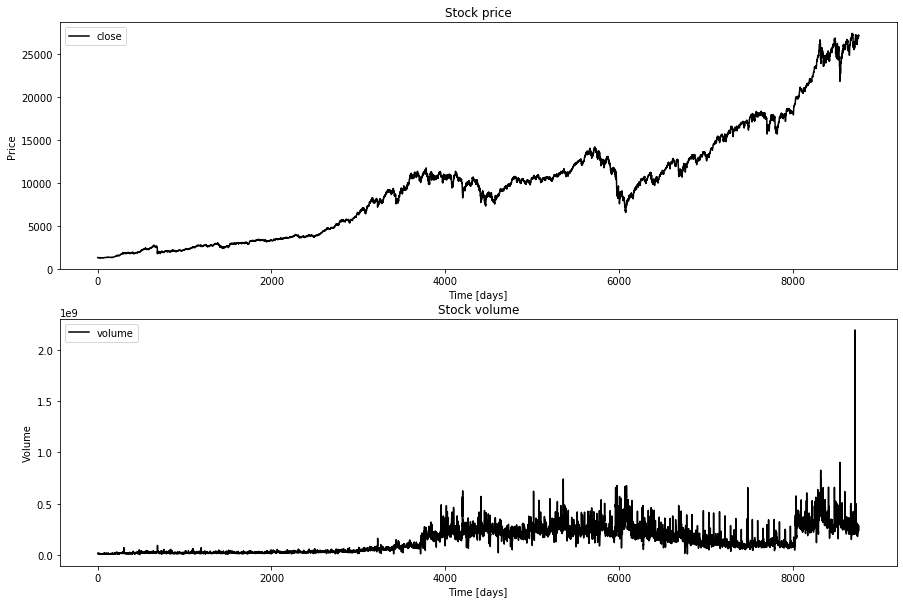

In [6]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(df['Close'], color='black', label='close')
plt.title('Stock price')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')


plt.subplot(2, 1, 2)
plt.plot(df['Volume'], color='black', label='volume')
plt.title('Stock volume')
plt.xlabel('Time [days]')
plt.ylabel('Volume')
plt.legend(loc='best')

In [7]:
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['Open'] = min_max_scaler.fit_transform(df['Open'].to_numpy().reshape(-1, 1))
    df['Low'] = min_max_scaler.fit_transform(df['Low'].to_numpy().reshape(-1, 1))    
    df['High'] = min_max_scaler.fit_transform(df['High'].to_numpy().reshape(-1, 1))    
    df['Close'] = min_max_scaler.fit_transform(df['Close'].to_numpy().reshape(-1, 1))
    df['sma5'] = min_max_scaler.fit_transform(df['sma5'].to_numpy().reshape(-1, 1))
    df['sma10'] = min_max_scaler.fit_transform(df['sma10'].to_numpy().reshape(-1, 1))
    df['sma25'] = min_max_scaler.fit_transform(df['sma25'].to_numpy().reshape(-1, 1))
    df['sma75'] = min_max_scaler.fit_transform(df['sma75'].to_numpy().reshape(-1, 1))
    df['sma125'] = min_max_scaler.fit_transform(df['sma125'].to_numpy().reshape(-1, 1))
    df['sma200'] = min_max_scaler.fit_transform(df['sma200'].to_numpy().reshape(-1, 1))
    #df['Volume'] = min_max_scaler.fit_transform(df['Volume'].to_numpy().reshape(-1, 1))  
    return df

def load_data(stock, seq_len):
    data_raw = stock.as_matrix()
    data = list()
    for index in range(len(data_raw) - seq_len):
        data.append(data_raw[index: index+seq_len])
    data = np.array(data)
    val_set_size = int(np.round(val_set_size_percentage/100*data.shape[0]))
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]))
    train_set_size = data.shape[0] - (val_set_size + test_set_size)
    
    x_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, :]
    
    x_val = data[train_set_size:train_set_size + val_set_size, :-1, :]
    y_val = data[train_set_size:train_set_size + val_set_size, -1, :]
    
    x_test = data[train_set_size+val_set_size:,:-1,:]
    y_test = data[train_set_size+val_set_size:,-1,:]
    
    return [x_train, y_train, x_val, y_val, x_test, y_test]

In [8]:
df_index = df.drop('Date', axis=1)
df_index = df_index.drop('Volume', axis=1)


cols = list(df_index.columns.values)
print('Col : ', cols)

# rearrange columns ,for training with volume
# n_cols = cols[:3] + [cols[-1]] + [cols[-2]]
# df_index = df_index[n_cols] 

# print("new Cols: ",list(df_index.columns.values))





# parameter for preprocessing #

val_set_size_percentage = 10
test_set_size_percentage = 10
seq_len = 20

#*****************************#

# normalize index
df_index_norm = normalize_data(df_index)

# split train, val, test data

x_train, y_train, x_val, y_val, x_test, y_test = load_data(df_index_norm, seq_len)

print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_val.shape = ', x_val.shape)
print('y_val.shape = ', y_val.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ', y_test.shape)

Col :  ['Open', 'High', 'Low', 'Close', 'sma5', 'sma10', 'sma25', 'sma75', 'sma125', 'sma200']
x_train.shape =  (6994, 19, 10)
y_train.shape =  (6994, 10)
x_val.shape =  (874, 19, 10)
y_val.shape =  (874, 10)
x_test.shape =  (874, 19, 10)
y_test.shape =  (874, 10)


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [9]:
print(y_train[0]);
print("\n")
print(x_train[0]); 

[0.00124689 0.00160513 0.00141143 0.00168701 0.00130162 0.00112502
 0.00095598 0.0017336  0.00174795 0.0017656 ]


[[0.00130202 0.00169347 0.00120344 0.00193628 0.00177368 0.00150791
  0.00120864 0.00198974 0.00200621 0.00202647]
 [0.00205429 0.002061   0.00166548 0.00175479 0.00159171 0.00132562
  0.00102468 0.00180324 0.00181817 0.00183652]
 [0.00151334 0.00161354 0.0014241  0.00171229 0.00154909 0.00128293
  0.0009816  0.00175957 0.00177413 0.00179204]
 [0.00127216 0.00133474 0.00131396 0.00136577 0.00120165 0.00093488
  0.00063035 0.00140348 0.0014151  0.00142939]
 [0.0010861  0.00167244 0.00128403 0.00183902 0.00155846 0.00141023
  0.00111006 0.0018898  0.00190545 0.00192468]
 [0.00192757 0.00190917 0.00165281 0.00165332 0.00150172 0.0012237
  0.00092182 0.00169897 0.00171304 0.00173033]
 [0.00157651 0.00165561 0.00151734 0.00147566 0.00144574 0.00104526
  0.00074174 0.0015164  0.00152896 0.00154439]
 [0.00158072 0.00175275 0.00169925 0.00183902 0.00147116 0.00141023
  0.00111006 

In [10]:
df_index.head(20)

,Open,High,Low,Close,sma5,sma10,sma25,sma75,sma125,sma200
0,0.001302,0.001693,0.001203,0.001936,0.001774,0.001508,0.001209,0.001990,0.002006,0.002026
1,0.002054,0.002061,0.001665,0.001755,0.001592,0.001326,0.001025,0.001803,0.001818,0.001837
2,0.001513,0.001614,0.001424,0.001712,0.001549,0.001283,0.000982,0.001760,0.001774,0.001792
3,0.001272,0.001335,0.001314,0.001366,0.001202,0.000935,0.000630,0.001403,0.001415,0.001429
4,0.001086,0.001672,0.001284,0.001839,0.001558,0.001410,0.001110,0.001890,0.001905,0.001925
5,0.001928,0.001909,0.001653,0.001653,0.001502,0.001224,0.000922,0.001699,0.001713,0.001730
6,0.001577,0.001656,0.001517,0.001476,0.001446,0.001045,0.000742,0.001516,0.001529,0.001544
7,0.001581,0.001753,0.001699,0.001839,0.001471,0.001410,0.001110,0.001890,0.001905,0.001925
8,0.001775,0.001757,0.001759,0.001835,0.001565,0.001406,0.001106,0.001885,0.001901,0.001920
9,0.001695,0.001550,0.001271,0.001302,0.001458,0.001242,0.000566,0.001338,0.001349,0.001363


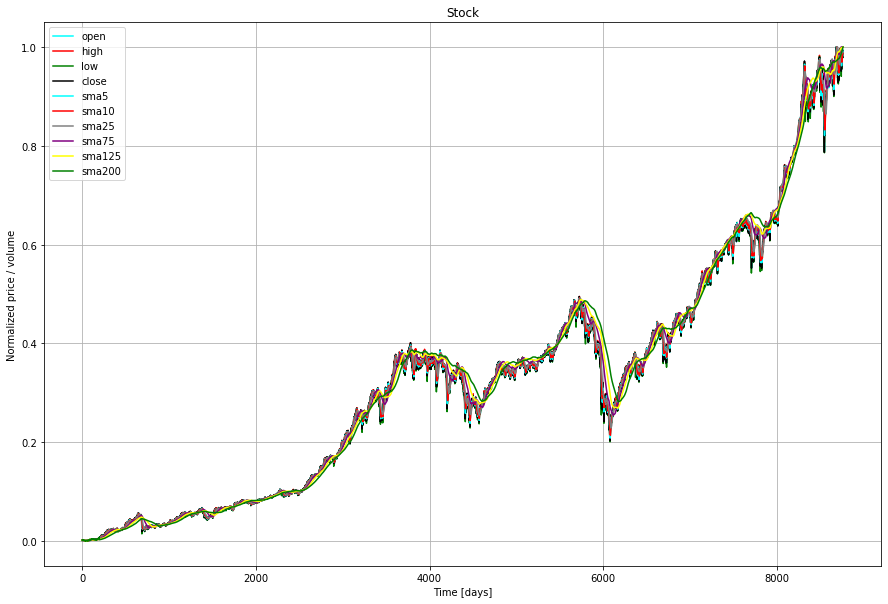

In [11]:
plt.figure(figsize=(15, 10))
plt.grid(True)
plt.plot(df_index_norm['Open'], color='cyan', label='open')
plt.plot(df_index_norm['High'], color='red', label='high')
plt.plot(df_index_norm['Low'], color='green', label='low')
plt.plot(df_index_norm['Close'], color='black', label='close')
plt.plot(df_index_norm['sma5'], color='cyan', label='sma5')
plt.plot(df_index_norm['sma10'], color='red', label='sma10')
plt.plot(df_index_norm['sma25'], color='gray', label='sma25')
plt.plot(df_index_norm['sma75'], color='purple', label='sma75')
plt.plot(df_index_norm['sma125'], color='yellow', label='sma125')
plt.plot(df_index_norm['sma200'], color='green', label='sma200')
plt.title('Stock')
plt.xlabel('Time [days]')
plt.ylabel('Normalized price / volume')
plt.legend(loc='best')
plt.show()

In [12]:
from tensorflow.keras import backend as K
K.clear_session()

In [13]:
from tensorflow.keras.layers import Bidirectional,TimeDistributed,BatchNormalization,Flatten,LeakyReLU,Dropout

def get_bi_gru():
    
    input1 = Input(shape=(19,10,))
    x = Bidirectional(LSTM(256, return_sequences=True,  kernel_initializer='Orthogonal'))(input1)
    x = TimeDistributed(LeakyReLU())(x)
    x = TimeDistributed(BatchNormalization())(x)
    x = GRU(128,kernel_initializer='Orthogonal')(x)
    x =(LeakyReLU())(x)
    x = (BatchNormalization())(x)
    x = (Dropout(0.25))(x)
    out = Dense(10,kernel_initializer='he_normal')(x)

    
    
    model = Model(inputs=input1, outputs=out)
    model.compile(optimizer=Adam(0.005),
                loss='mse',
                metrics=['mse'])   
    
    return model

In [14]:
model = get_bi_gru()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 19, 10)]          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 19, 512)           546816    
_________________________________________________________________
time_distributed (TimeDistri (None, 19, 512)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 19, 512)           2048      
_________________________________________________________________
gru (GRU)                    (None, 128)               246528    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512   

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
print('start training ')


weight_path_model = "saved_model/model_sma_NoVOL.h5"
callbacks_list_model = [
    ModelCheckpoint(
             weight_path_model,
            save_best_only=True,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            verbose=2
        ),
    ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=4, min_lr=0.0001)
]

#################
batch_size = 64
epochs = 300
#################

history = model.fit(x_train, y_train, epochs=epochs, verbose=1, callbacks=callbacks_list_model,
          validation_data=(x_val, y_val),batch_size=batch_size) #batch_size=batch_size




start training 
Train on 6994 samples, validate on 874 samples
Epoch 1/300
6976/6994 [============================>.] - ETA: 0s - loss: 0.2910 - mse: 0.2910
Epoch 00001: val_loss improved from inf to 0.46412, saving model to saved_model/model_sma_NoVOL.h5
6994/6994 [==============================] - 40s 6ms/sample - loss: 0.2903 - mse: 0.2903 - val_loss: 0.4641 - val_mse: 0.4641
Epoch 2/300
6976/6994 [============================>.] - ETA: 0s - loss: 0.0039 - mse: 0.0039
Epoch 00002: val_loss improved from 0.46412 to 0.19691, saving model to saved_model/model_sma_NoVOL.h5
6994/6994 [==============================] - 25s 4ms/sample - loss: 0.0039 - mse: 0.0039 - val_loss: 0.1969 - val_mse: 0.1969
Epoch 3/300
6976/6994 [============================>.] - ETA: 0s - loss: 0.0025 - mse: 0.0025
Epoch 00003: val_loss improved from 0.19691 to 0.09758, saving model to saved_model/model_sma_NoVOL.h5
6994/6994 [==============================] - 25s 4ms/sample - loss: 0.0025 - mse: 0.0025 - val_los

6976/6994 [============================>.] - ETA: 0s - loss: 9.3376e-04 - mse: 9.3376e-04
Epoch 00028: val_loss did not improve from 0.00062
6994/6994 [==============================] - 28s 4ms/sample - loss: 9.3255e-04 - mse: 9.3255e-04 - val_loss: 8.6895e-04 - val_mse: 8.6895e-04
Epoch 29/300
6976/6994 [============================>.] - ETA: 0s - loss: 0.0011 - mse: 0.0011
Epoch 00029: val_loss did not improve from 0.00062
6994/6994 [==============================] - 28s 4ms/sample - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0056 - val_mse: 0.0056
Epoch 30/300
6976/6994 [============================>.] - ETA: 0s - loss: 9.1572e-04 - mse: 9.1572e-04
Epoch 00030: val_loss did not improve from 0.00062
6994/6994 [==============================] - 23s 3ms/sample - loss: 9.3114e-04 - mse: 9.3114e-04 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 31/300
6976/6994 [============================>.] - ETA: 0s - loss: 8.6441e-04 - mse: 8.6441e-04
Epoch 00031: val_loss improved from 0.00062 to 0.00038

Epoch 56/300
6976/6994 [============================>.] - ETA: 0s - loss: 7.6560e-04 - mse: 7.6560e-04
Epoch 00056: val_loss did not improve from 0.00015
6994/6994 [==============================] - 36s 5ms/sample - loss: 7.7378e-04 - mse: 7.7378e-04 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 57/300
6976/6994 [============================>.] - ETA: 0s - loss: 7.4004e-04 - mse: 7.4004e-04
Epoch 00057: val_loss did not improve from 0.00015
6994/6994 [==============================] - 26s 4ms/sample - loss: 7.4129e-04 - mse: 7.4129e-04 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 58/300
6976/6994 [============================>.] - ETA: 0s - loss: 7.3833e-04 - mse: 7.3833e-04
Epoch 00058: val_loss did not improve from 0.00015
6994/6994 [==============================] - 26s 4ms/sample - loss: 7.3725e-04 - mse: 7.3725e-04 - val_loss: 4.8137e-04 - val_mse: 4.8137e-04
Epoch 59/300
6976/6994 [============================>.] - ETA: 0s - loss: 7.0436e-04 - mse: 7.0436e-04
Epoch 00059: val_loss did

Epoch 84/300
6976/6994 [============================>.] - ETA: 0s - loss: 6.2361e-04 - mse: 6.2361e-04
Epoch 00084: val_loss did not improve from 0.00015
6994/6994 [==============================] - 39s 6ms/sample - loss: 6.2558e-04 - mse: 6.2558e-04 - val_loss: 4.7500e-04 - val_mse: 4.7500e-04
Epoch 85/300
6976/6994 [============================>.] - ETA: 0s - loss: 6.0428e-04 - mse: 6.0428e-04
Epoch 00085: val_loss did not improve from 0.00015
6994/6994 [==============================] - 35s 5ms/sample - loss: 6.0494e-04 - mse: 6.0494e-04 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 86/300
6976/6994 [============================>.] - ETA: 0s - loss: 7.5452e-04 - mse: 7.5452e-04
Epoch 00086: val_loss did not improve from 0.00015
6994/6994 [==============================] - 36s 5ms/sample - loss: 7.5736e-04 - mse: 7.5736e-04 - val_loss: 4.7231e-04 - val_mse: 4.7231e-04
Epoch 87/300
6976/6994 [============================>.] - ETA: 0s - loss: 7.3948e-04 - mse: 7.3948e-04
Epoch 00087: val_

Epoch 112/300
6976/6994 [============================>.] - ETA: 0s - loss: 6.2778e-04 - mse: 6.2778e-04
Epoch 00112: val_loss did not improve from 0.00011
6994/6994 [==============================] - 130s 19ms/sample - loss: 6.3622e-04 - mse: 6.3622e-04 - val_loss: 9.8827e-04 - val_mse: 9.8827e-04
Epoch 113/300
6976/6994 [============================>.] - ETA: 0s - loss: 6.8049e-04 - mse: 6.8049e-04
Epoch 00113: val_loss did not improve from 0.00011
6994/6994 [==============================] - 23s 3ms/sample - loss: 6.8287e-04 - mse: 6.8287e-04 - val_loss: 3.4016e-04 - val_mse: 3.4016e-04
Epoch 114/300
6976/6994 [============================>.] - ETA: 0s - loss: 5.8758e-04 - mse: 5.8758e-04
Epoch 00114: val_loss did not improve from 0.00011
6994/6994 [==============================] - 24s 3ms/sample - loss: 5.8764e-04 - mse: 5.8764e-04 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 115/300
6976/6994 [============================>.] - ETA: 0s - loss: 7.0635e-04 - mse: 7.0635e-04
Epoch 00115

Epoch 140/300
6976/6994 [============================>.] - ETA: 0s - loss: 6.3834e-04 - mse: 6.3834e-04
Epoch 00140: val_loss did not improve from 0.00011
6994/6994 [==============================] - 27s 4ms/sample - loss: 6.3866e-04 - mse: 6.3866e-04 - val_loss: 1.7306e-04 - val_mse: 1.7306e-04
Epoch 141/300
6976/6994 [============================>.] - ETA: 0s - loss: 5.8696e-04 - mse: 5.8696e-04
Epoch 00141: val_loss did not improve from 0.00011
6994/6994 [==============================] - 28s 4ms/sample - loss: 5.9743e-04 - mse: 5.9743e-04 - val_loss: 4.4769e-04 - val_mse: 4.4769e-04
Epoch 142/300
6976/6994 [============================>.] - ETA: 0s - loss: 6.1433e-04 - mse: 6.1433e-04
Epoch 00142: val_loss did not improve from 0.00011
6994/6994 [==============================] - 26s 4ms/sample - loss: 6.1517e-04 - mse: 6.1517e-04 - val_loss: 7.7654e-04 - val_mse: 7.7654e-04
Epoch 143/300
6976/6994 [============================>.] - ETA: 0s - loss: 6.6800e-04 - mse: 6.6800e-04
Epoch

Epoch 168/300
6976/6994 [============================>.] - ETA: 0s - loss: 5.5972e-04 - mse: 5.5972e-04
Epoch 00168: val_loss did not improve from 0.00011
6994/6994 [==============================] - 23s 3ms/sample - loss: 5.6151e-04 - mse: 5.6151e-04 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 169/300
6976/6994 [============================>.] - ETA: 0s - loss: 6.4821e-04 - mse: 6.4821e-04
Epoch 00169: val_loss did not improve from 0.00011
6994/6994 [==============================] - 23s 3ms/sample - loss: 6.4718e-04 - mse: 6.4718e-04 - val_loss: 2.5675e-04 - val_mse: 2.5675e-04
Epoch 170/300
6976/6994 [============================>.] - ETA: 0s - loss: 4.9761e-04 - mse: 4.9761e-04
Epoch 00170: val_loss did not improve from 0.00011
6994/6994 [==============================] - 24s 3ms/sample - loss: 5.0368e-04 - mse: 5.0368e-04 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 171/300
6976/6994 [============================>.] - ETA: 0s - loss: 5.5467e-04 - mse: 5.5467e-04
Epoch 00171: val_loss

Epoch 196/300
6976/6994 [============================>.] - ETA: 0s - loss: 4.9963e-04 - mse: 4.9963e-04
Epoch 00196: val_loss did not improve from 0.00007
6994/6994 [==============================] - 26s 4ms/sample - loss: 4.9959e-04 - mse: 4.9959e-04 - val_loss: 1.3780e-04 - val_mse: 1.3780e-04
Epoch 197/300
6976/6994 [============================>.] - ETA: 0s - loss: 5.8144e-04 - mse: 5.8144e-04
Epoch 00197: val_loss did not improve from 0.00007
6994/6994 [==============================] - 25s 4ms/sample - loss: 5.8109e-04 - mse: 5.8109e-04 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 198/300
6976/6994 [============================>.] - ETA: 0s - loss: 6.3647e-04 - mse: 6.3647e-04
Epoch 00198: val_loss did not improve from 0.00007
6994/6994 [==============================] - 23s 3ms/sample - loss: 6.3578e-04 - mse: 6.3578e-04 - val_loss: 0.0022 - val_mse: 0.0022
Epoch 199/300
6976/6994 [============================>.] - ETA: 0s - loss: 5.8695e-04 - mse: 5.8695e-04
Epoch 00199: val_loss

Epoch 224/300
6976/6994 [============================>.] - ETA: 0s - loss: 6.1249e-04 - mse: 6.1249e-04
Epoch 00224: val_loss did not improve from 0.00007
6994/6994 [==============================] - 26s 4ms/sample - loss: 6.1141e-04 - mse: 6.1141e-04 - val_loss: 8.4590e-04 - val_mse: 8.4590e-04
Epoch 225/300
6976/6994 [============================>.] - ETA: 0s - loss: 5.4342e-04 - mse: 5.4342e-04
Epoch 00225: val_loss did not improve from 0.00007
6994/6994 [==============================] - 25s 4ms/sample - loss: 5.4371e-04 - mse: 5.4371e-04 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 226/300
6976/6994 [============================>.] - ETA: 0s - loss: 5.0035e-04 - mse: 5.0035e-04
Epoch 00226: val_loss did not improve from 0.00007
6994/6994 [==============================] - 23s 3ms/sample - loss: 5.0196e-04 - mse: 5.0196e-04 - val_loss: 1.7474e-04 - val_mse: 1.7474e-04
Epoch 227/300
6976/6994 [============================>.] - ETA: 0s - loss: 5.4229e-04 - mse: 5.4229e-04
Epoch 00227: 

Epoch 252/300
6976/6994 [============================>.] - ETA: 0s - loss: 5.1630e-04 - mse: 5.1630e-04
Epoch 00252: val_loss did not improve from 0.00007
6994/6994 [==============================] - 22s 3ms/sample - loss: 5.1580e-04 - mse: 5.1580e-04 - val_loss: 0.0014 - val_mse: 0.0014
Epoch 253/300
6976/6994 [============================>.] - ETA: 0s - loss: 5.3715e-04 - mse: 5.3715e-04
Epoch 00253: val_loss did not improve from 0.00007
6994/6994 [==============================] - 23s 3ms/sample - loss: 5.4025e-04 - mse: 5.4025e-04 - val_loss: 9.4360e-04 - val_mse: 9.4360e-04
Epoch 254/300
6976/6994 [============================>.] - ETA: 0s - loss: 5.4649e-04 - mse: 5.4649e-04
Epoch 00254: val_loss did not improve from 0.00007
6994/6994 [==============================] - 33s 5ms/sample - loss: 5.4610e-04 - mse: 5.4610e-04 - val_loss: 1.3027e-04 - val_mse: 1.3027e-04
Epoch 255/300
6976/6994 [============================>.] - ETA: 0s - loss: 5.6720e-04 - mse: 5.6720e-04
Epoch 00255: 

Epoch 280/300
6976/6994 [============================>.] - ETA: 0s - loss: 5.5463e-04 - mse: 5.5463e-04
Epoch 00280: val_loss did not improve from 0.00007
6994/6994 [==============================] - 24s 3ms/sample - loss: 5.5536e-04 - mse: 5.5536e-04 - val_loss: 9.3930e-04 - val_mse: 9.3930e-04
Epoch 281/300
6976/6994 [============================>.] - ETA: 0s - loss: 6.2305e-04 - mse: 6.2305e-04
Epoch 00281: val_loss did not improve from 0.00007
6994/6994 [==============================] - 22s 3ms/sample - loss: 6.2364e-04 - mse: 6.2364e-04 - val_loss: 9.7289e-04 - val_mse: 9.7289e-04
Epoch 282/300
6976/6994 [============================>.] - ETA: 0s - loss: 5.9907e-04 - mse: 5.9907e-04
Epoch 00282: val_loss did not improve from 0.00007
6994/6994 [==============================] - 26s 4ms/sample - loss: 5.9933e-04 - mse: 5.9933e-04 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 283/300
6976/6994 [============================>.] - ETA: 0s - loss: 4.9989e-04 - mse: 4.9989e-04
Epoch 00283: 

In [16]:
print(history.history.keys())

dict_keys(['loss', 'mse', 'val_loss', 'val_mse', 'lr'])


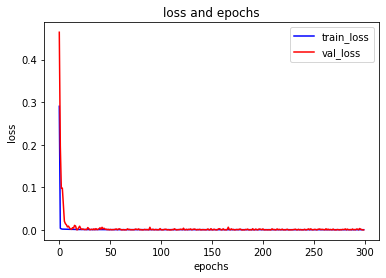

In [17]:
plt.title("loss and epochs")
plt.plot(history.history['loss'],color = 'blue',label="train_loss")
plt.plot(history.history['val_loss'],color = 'red',label="val_loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()


In [18]:
# #Load the minimum loss weight 
# model = get_bi_gru()
# model.load_weights("./saved_model/the_best_one.h5")

In [19]:
# # Load saved model 
# from tensorflow.keras.models import load_model
# model = load_model("./saved_model/the_best_one.h5")

In [20]:
x_train.shape
y_train.shape

(6994, 10)

In [21]:
y_train_pred = model.predict(x_train)
y_val_pred = model.predict(x_val)
y_test_pred = model.predict(x_test)

In [22]:
print(y_test_pred[0])

[0.63551635 0.63237023 0.6213771  0.63120925 0.62693197 0.6140651
 0.6283769  0.62461805 0.61313015 0.6060252 ]


In [23]:
print( y_test_pred[:, 1][0])

0.63237023


In [24]:
def plot_compare(x):
    Col = {'Open':0, 'High':1, 'Low':2, 'Close':3}
    ft = Col[x]
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)

    plt.plot(np.arange(y_train.shape[0]), y_train[:, ft], color='blue', label='train target')

    plt.plot(np.arange(y_train.shape[0], y_train.shape[0] + y_val.shape[0]), y_val[:, ft], 
             color='gray', label='val target')
    plt.plot(np.arange(y_train.shape[0] + y_val.shape[0], y_train.shape[0] + y_val.shape[0] + y_test.shape[0]),
            y_test[:, ft], color='black', label='test target')
    plt.plot(np.arange(y_train_pred.shape[0]), y_train_pred[:, ft],
            color='red', label='train prediction') 
    plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0] + y_val_pred.shape[0]),
            y_val_pred[:, ft], color='orange', label='val prediction')
    plt.plot(np.arange(y_train_pred.shape[0] + y_val_pred.shape[0],
            y_train_pred.shape[0] + y_val_pred.shape[0] + y_test_pred.shape[0]),
            y_test_pred[:, ft], color ='green', label='test prediction')
    plt.title('past and future stock price')
    plt.xlabel('Time [Days]')
    plt.ylabel('Normalized price')
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(y_train.shape[0], y_train.shape[0] + y_test.shape[0]),
            y_test[:, ft], color='black', label='test target')
    plt.plot(np.arange(y_train.shape[0], y_train.shape[0] + y_test_pred.shape[0]),
            y_test_pred[:, ft], color='green', label='test prediction')
    plt.title('future stock prices '+x)
    plt.xlabel('Time [Days]')
    plt.ylabel('Normalized price')
    plt.legend(loc='best')



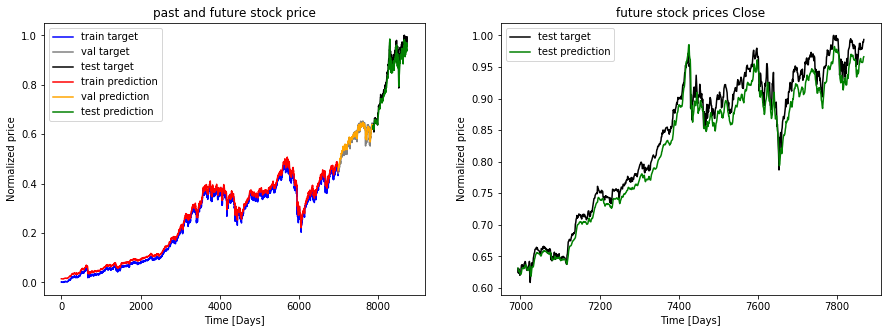

In [25]:
plot_compare('Close')

In [29]:
model.save("saved_model/best_one.h5")

In [30]:
model.evaluate(x_test,y_test)

874/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.0009217861764350356, 0.0009217861]

In [31]:
model.evaluate(x_val,y_val)

874/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.00017298993031713831, 0.00017298992]

In [32]:
model.evaluate(x_train,y_train)

6994/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.00011337168293616001, 0.00011337167]